# Part 1: GAN

# Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


In [2]:
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])


transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Check dataset information
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 60000
Test dataset length: 10000


In [3]:
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


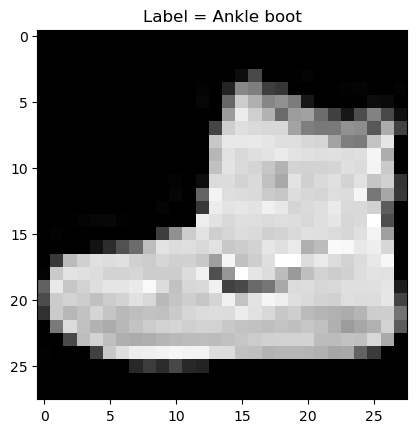

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def print_image(img, label):
    img_norm = denorm(img)
    plt.imshow(img_norm[0], cmap='gray')
    plt.title(f'Label = {class_names[label]}')
    

img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)
print_image(img, label)

In [5]:
# Break Data in mini batches
from torch.utils.data import DataLoader

batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

first batch
torch.Size([100, 1, 28, 28])


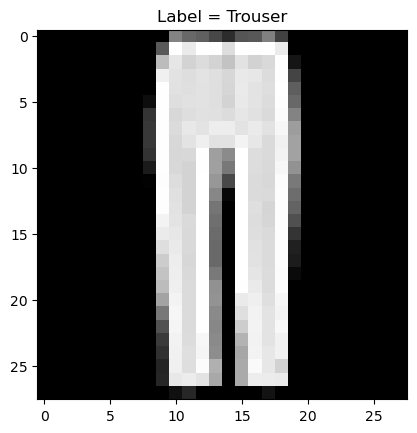

In [6]:
for img_batch, label_batch in train_loader:
    print('first batch')
    print(img_batch.shape)
    print_image(img=img_batch[0], label=label_batch[0].item())
    break

In [7]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage


def show_images(images_path):
    
    n = len(images_path)
    plt.figure(figsize=(5*n, 5))
    
    for i, path in enumerate(images_path):
        # Plot first image
        plt.subplot(1, n, i+1)
        image = PILImage.open(path)
        plt.imshow(image)
        plt.title(path)
        plt.axis('off')
        
    plt.show()
    

# Step2. Train the GAN model to produce images in this new domain.

In [8]:
# Setting Device configuration to get performance boost

device = torch.device('cuda' if torch.cuda.is_available() else ( 
    'mps' if torch.backends.mps.is_available() else 'cpu'))

# device = "cpu"
device

device(type='mps')

In [9]:
image_size = 784
hidden_size = 256

## Discriminator Network


In [10]:
import torch.nn as nn

def discriminator_network():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

D = discriminator_network()
D.to(device);

## Generator Network

In [11]:
latent_size = 64

def generator_network():
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

G = generator_network()

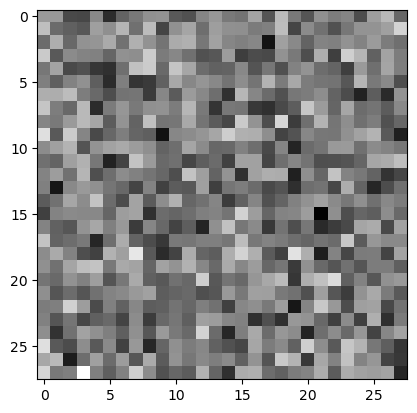

In [12]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray');

In [13]:
G.to(device);

In [14]:
def reset_grad(g_optimizer, d_optimizer):
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(G, D, images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad(g_optimizer, d_optimizer)
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [15]:
def train_generator(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad(g_optimizer, d_optimizer)
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [16]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

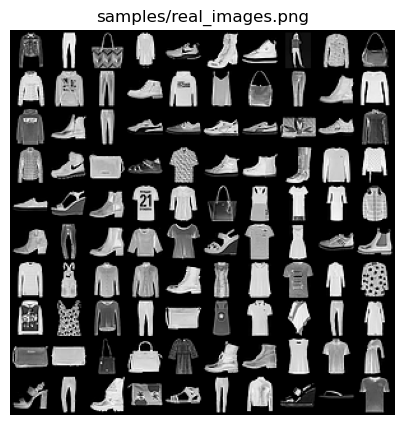

In [17]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

show_images([os.path.join(sample_dir, 'real_images.png')])

In [18]:
def save_fake_images(G, index, sample_dir):
    sample_vectors = torch.randn(batch_size, latent_size).to(device)

    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname  = 'fake_images-{0:0=4d}.png'.format(index)
    print('\tSaving ',  os.path.join(sample_dir, fake_fname))
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# # Before training
# save_fake_images(G, 0, sample_dir=sample_dir)
# show_images([os.path.join(sample_dir, 'fake_images-0000.png')])

In [19]:
def train_gan(G, D, data_loader, num_epochs, sample_dir, 
              batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    save_fake_images(G, 0, sample_dir=sample_dir)
    show_images([os.path.join(sample_dir, 'fake_images-0000.png')])
    
    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):
            
            # Load a batch & transform to vectors
            images = images.reshape(batch_size, -1).to(device)

            # Train the discriminator and generator
            d_loss, real_score, fake_score = train_discriminator(G, D, images, batch_size, latent_size, 
                                                                 criterion, g_optimizer, d_optimizer)
            g_loss, fake_images = train_generator(G, D, batch_size, latent_size, 
                                                  criterion, g_optimizer, d_optimizer)

            # Inspect the losses
            if (i+1) % (total_step//3) == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' + 
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

                
        # Sample and save images
        save_fake_images(G, epoch+1, sample_dir)

    return d_losses, g_losses, real_scores, fake_scores
        
        

	Saving  samples/fake_images-0000.png


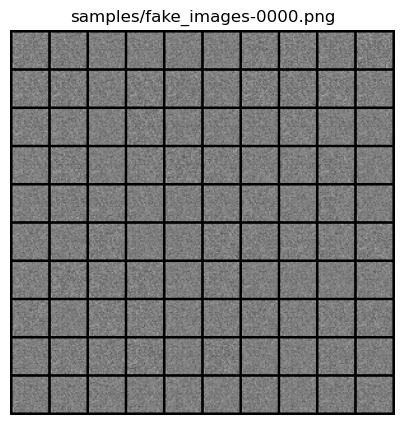

Epoch [0/20], Step [200/600], d_loss: 0.0806, g_loss: 3.8522, D(x): 0.98, D(G(z)): 0.05
Epoch [0/20], Step [400/600], d_loss: 0.1061, g_loss: 5.9600, D(x): 0.97, D(G(z)): 0.04
Epoch [0/20], Step [600/600], d_loss: 0.0499, g_loss: 5.0477, D(x): 0.98, D(G(z)): 0.03
	Saving  samples/fake_images-0001.png
Epoch [1/20], Step [200/600], d_loss: 0.0439, g_loss: 4.6483, D(x): 0.99, D(G(z)): 0.03
Epoch [1/20], Step [400/600], d_loss: 0.1137, g_loss: 4.3174, D(x): 0.97, D(G(z)): 0.03
Epoch [1/20], Step [600/600], d_loss: 0.0551, g_loss: 4.1713, D(x): 1.00, D(G(z)): 0.05
	Saving  samples/fake_images-0002.png
Epoch [2/20], Step [200/600], d_loss: 0.0192, g_loss: 5.7587, D(x): 0.99, D(G(z)): 0.01
Epoch [2/20], Step [400/600], d_loss: 0.0328, g_loss: 5.8110, D(x): 0.99, D(G(z)): 0.02
Epoch [2/20], Step [600/600], d_loss: 0.0309, g_loss: 10.8426, D(x): 0.98, D(G(z)): 0.00
	Saving  samples/fake_images-0003.png
Epoch [3/20], Step [200/600], d_loss: 0.0807, g_loss: 4.2203, D(x): 0.99, D(G(z)): 0.05
Epoch

In [20]:
num_epochs  = 20
criterion   = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

d_losses, g_losses, real_scores, fake_scores = train_gan(G, D, train_loader, num_epochs, sample_dir, 
                                                         batch_size, latent_size, 
                                                         criterion, g_optimizer, d_optimizer)

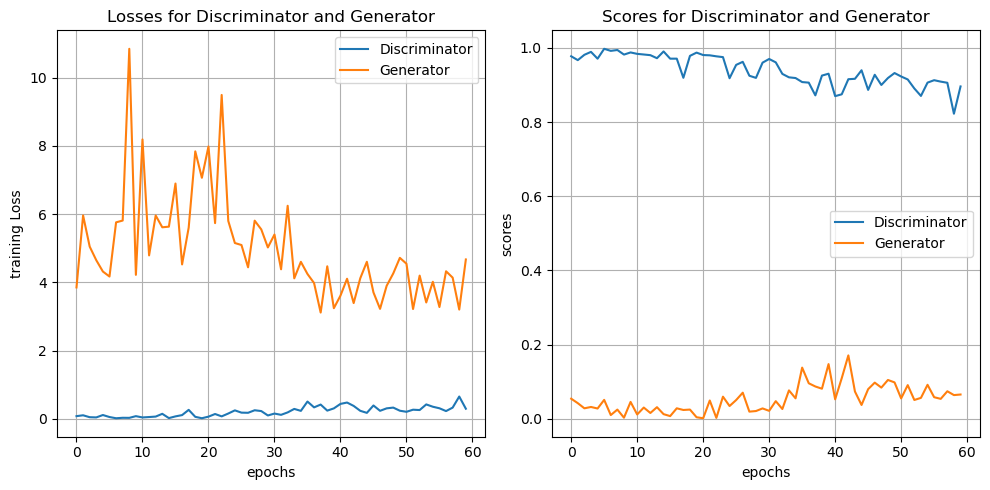

In [21]:
def plot_side_by_side(d_losses, g_losses, real_scores, fake_scores):
    
    plt.figure(figsize=(10,5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, '-')
    plt.plot(g_losses, '-')
    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Losses for Discriminator and Generator")
    
    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Scores for Discriminator and Generator")
    
    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()
    
plot_side_by_side(d_losses, g_losses, real_scores, fake_scores)

# Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.


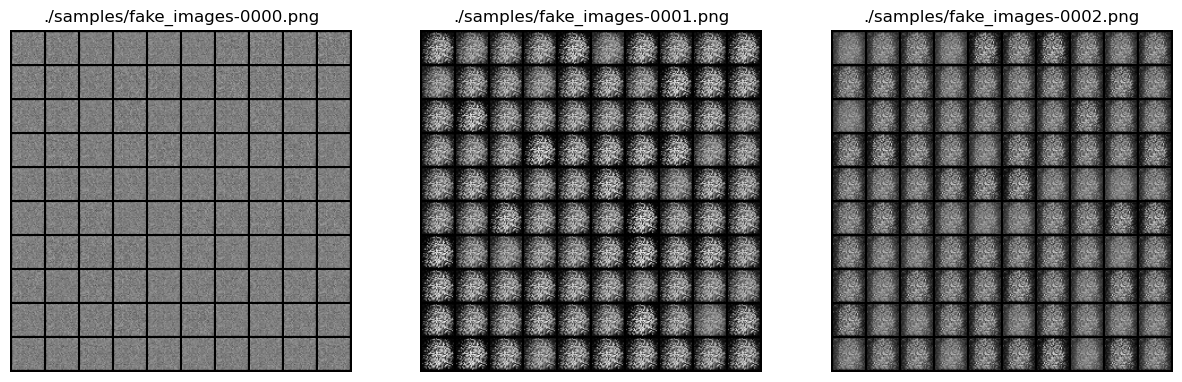

In [23]:
show_images(['./samples/fake_images-0000.png', 
             './samples/fake_images-0001.png', './samples/fake_images-0002.png'])


# Step4. Save the model weights in the folder to be used later.


In [24]:
# Create a dictionary to store necessary information
d_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': d_optimizer.state_dict(),
}

torch.save(d_checkpoint, f'{sample_dir}/discriminator_checkpoint.ckpt')

In [25]:
# Create a dictionary to store necessary information
g_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': g_optimizer.state_dict(),
}

torch.save(g_checkpoint, f'{sample_dir}/generator_checkpoint.ckpt')

# Step5. Load the model using the saved weights.


In [26]:
Dl= discriminator_network()

# Load the checkpoint
d_checkpoint = torch.load(f'{sample_dir}/discriminator_checkpoint.ckpt')

# Load model weights and optimizer state
Dl.load_state_dict(d_checkpoint['model_state_dict'])
d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])
num_epoch = d_checkpoint['epoch']

print(f"Discriminator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Dl.state_dict():
    print("\t", param_tensor, "\t", Dl.state_dict()[param_tensor].size())

Discriminator Model's training for 20 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 784])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([1, 256])
	 4.bias 	 torch.Size([1])


In [27]:
Gl= generator_network()

# Load the checkpoint
g_checkpoint = torch.load(f'{sample_dir}/generator_checkpoint.ckpt')

# Load model weights and optimizer state
Gl.load_state_dict(g_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
num_epoch = g_checkpoint['epoch']

print(f"Generator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Gl.state_dict():
    print("\t", param_tensor, "\t", Gl.state_dict()[param_tensor].size())

Generator Model's training for 20 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 64])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([784, 256])
	 4.bias 	 torch.Size([784])


# Step 6: Re-train the GAN model to see if you can improve.


In [28]:
def discriminator_network_new():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

Dnew = discriminator_network_new()
Dnew.to(device);

In [29]:
def generator_network_new():
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size*2),
        nn.ReLU(),
        nn.Linear(hidden_size*2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

Gnew = generator_network_new()
Gnew.to(device);


	Saving  samples_new/fake_images-0000.png


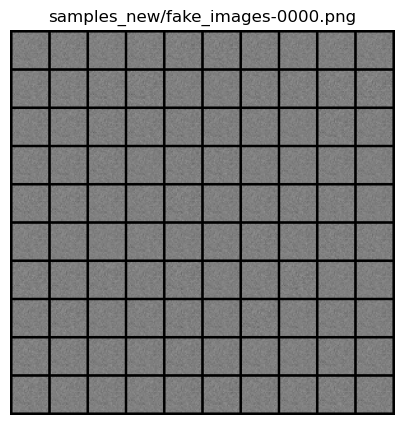

Epoch [0/20], Step [200/600], d_loss: 0.0537, g_loss: 4.8096, D(x): 0.98, D(G(z)): 0.03
Epoch [0/20], Step [400/600], d_loss: 0.0251, g_loss: 9.2356, D(x): 0.99, D(G(z)): 0.01
Epoch [0/20], Step [600/600], d_loss: 0.0608, g_loss: 7.5116, D(x): 0.97, D(G(z)): 0.01
	Saving  samples_new/fake_images-0001.png
Epoch [1/20], Step [200/600], d_loss: 0.0388, g_loss: 6.3527, D(x): 0.99, D(G(z)): 0.03
Epoch [1/20], Step [400/600], d_loss: 0.0338, g_loss: 5.3330, D(x): 1.00, D(G(z)): 0.03
Epoch [1/20], Step [600/600], d_loss: 0.0152, g_loss: 7.0795, D(x): 1.00, D(G(z)): 0.01
	Saving  samples_new/fake_images-0002.png
Epoch [2/20], Step [200/600], d_loss: 0.0397, g_loss: 7.1371, D(x): 0.99, D(G(z)): 0.01
Epoch [2/20], Step [400/600], d_loss: 0.0851, g_loss: 3.6041, D(x): 0.98, D(G(z)): 0.02
Epoch [2/20], Step [600/600], d_loss: 0.0819, g_loss: 7.3122, D(x): 0.97, D(G(z)): 0.01
	Saving  samples_new/fake_images-0003.png
Epoch [3/20], Step [200/600], d_loss: 0.1288, g_loss: 6.3191, D(x): 0.97, D(G(z)):

In [31]:
num_epochs  = 20
criterion_new   = nn.BCELoss()
d_optimizer_new = torch.optim.Adam(Dnew.parameters(), lr=0.0002)
g_optimizer_new = torch.optim.Adam(Gnew.parameters(), lr=0.0002)

sample_dir = "samples_new"

d_losses2, g_losses2, real_scores2, fake_scores2 = train_gan(Gnew, Dnew, train_loader, num_epochs, 
                                                             sample_dir, batch_size, latent_size, 
                                                             criterion_new, g_optimizer_new, d_optimizer_new)


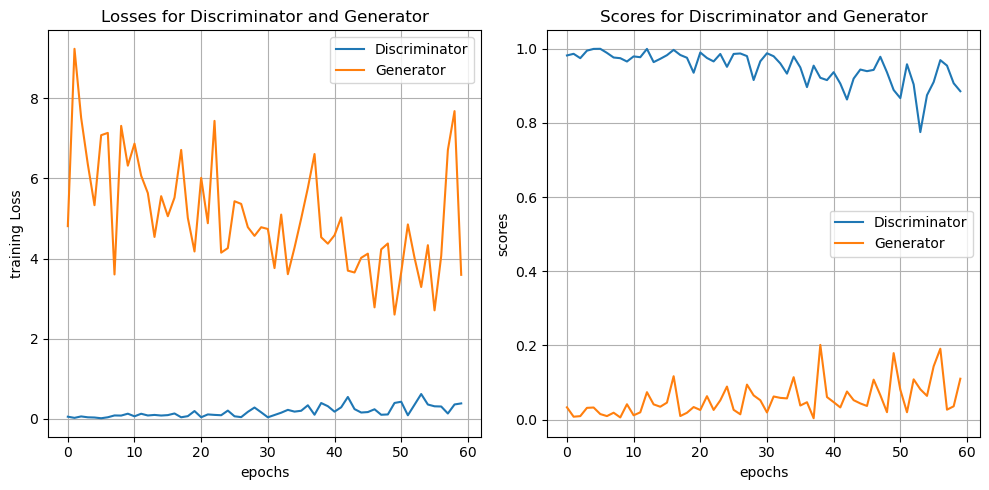

In [32]:
plot_side_by_side(d_losses2, g_losses2, real_scores2, fake_scores2)

In [34]:
# print("Simple GAN Training without any improvements")
# plot_side_by_side(d_losses, g_losses, real_scores, fake_scores)

# Step 7: Save the model weights without using checkpoints.


In [35]:
torch.save(Dnew.state_dict(), f'{sample_dir}/discriminator_model_weights.pth')
torch.save(Gnew.state_dict(), f'{sample_dir}/generator_model_weights.pth')

# Step 8: Load the model weights without using checkpoints

In [36]:
Dnew = discriminator_network_new()
Dnew.load_state_dict(torch.load(f'{sample_dir}/discriminator_model_weights.pth'))
print("\nDiscriminator Model's state_dict:")
for param_tensor in Dnew.state_dict():
    print("\t", param_tensor, "\t", Dnew.state_dict()[param_tensor].size())



Discriminator Model's state_dict:
	 0.weight 	 torch.Size([512, 784])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([1, 256])
	 6.bias 	 torch.Size([1])


In [37]:
Gnew = generator_network_new()
Gnew.load_state_dict(torch.load(f'{sample_dir}/generator_model_weights.pth'))
print("\nGenerator Model's state_dict:")
for param_tensor in Gnew.state_dict():
    print("\t", param_tensor, "\t", Gnew.state_dict()[param_tensor].size())


Generator Model's state_dict:
	 0.weight 	 torch.Size([512, 64])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([784, 256])
	 6.bias 	 torch.Size([784])



# Part-2 LSGAN

# Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

	Saving  sample_ls/fake_images-0000.png


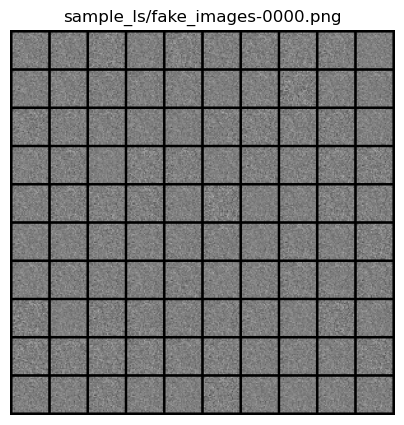

Epoch [0/20], Step [200/600], d_loss: 1.4047, g_loss: 0.6724, D(x): 0.50, D(G(z)): 0.51
Epoch [0/20], Step [400/600], d_loss: 1.4054, g_loss: 0.6725, D(x): 0.50, D(G(z)): 0.51
Epoch [0/20], Step [600/600], d_loss: 1.4004, g_loss: 0.6721, D(x): 0.50, D(G(z)): 0.51
	Saving  sample_ls/fake_images-0001.png
Epoch [1/20], Step [200/600], d_loss: 1.4058, g_loss: 0.6729, D(x): 0.50, D(G(z)): 0.51
Epoch [1/20], Step [400/600], d_loss: 1.4013, g_loss: 0.6722, D(x): 0.50, D(G(z)): 0.51
Epoch [1/20], Step [600/600], d_loss: 1.4027, g_loss: 0.6725, D(x): 0.50, D(G(z)): 0.51
	Saving  sample_ls/fake_images-0002.png
Epoch [2/20], Step [200/600], d_loss: 1.4020, g_loss: 0.6724, D(x): 0.50, D(G(z)): 0.51
Epoch [2/20], Step [400/600], d_loss: 1.4080, g_loss: 0.6727, D(x): 0.50, D(G(z)): 0.51
Epoch [2/20], Step [600/600], d_loss: 1.4030, g_loss: 0.6723, D(x): 0.50, D(G(z)): 0.51
	Saving  sample_ls/fake_images-0003.png
Epoch [3/20], Step [200/600], d_loss: 1.4074, g_loss: 0.6722, D(x): 0.50, D(G(z)): 0.51


In [38]:
def discriminator_network_ls():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

D_ls = discriminator_network_ls()
D_ls.to(device);

G_ls = generator_network()
G_ls.to(device);


sample_dir = "sample_ls"

num_epochs  = 20
criterion_ls   = nn.BCELoss()
d_optimizer_ls = torch.optim.Adam(Dnew.parameters(), lr=0.0002)
g_optimizer_ls = torch.optim.Adam(Gnew.parameters(), lr=0.0002)

d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls = train_gan(G_ls, D_ls, train_loader, 
                                                                     num_epochs, sample_dir, 
                                                                     batch_size, latent_size, criterion_ls, 
                                                                     g_optimizer_ls, d_optimizer_ls)



In [ ]:
def discriminator_network_new_ls():
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        )

D_ls_new = discriminator_network_new_ls()
D_ls_new.to(device);

G_ls_new = generator_network_new()
G_ls_new.to(device);


sample_dir = "sample_ls_new"

num_epochs  = 20
criterion_new   = nn.BCELoss()
d_optimizer_new = torch.optim.Adam(Dnew.parameters(), lr=0.0002)
g_optimizer_new = torch.optim.Adam(Gnew.parameters(), lr=0.0002)

d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new = train_gan(G_ls_new, 
                                                                                     D_ls_new, 
                                                                                     train_loader, 
                                                                                     num_epochs, 
                                                                                     sample_dir, 
                                                                                     batch_size, latent_size, 
                                                                                     criterion_new, 
                                                                                     g_optimizer_new, 
                                                                                     d_optimizer_new)